In [4]:
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import kstest

In [ ]:
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# List of continuous distributions in scipy.stats to test
distribution_names = [
    'norm',
    't',
    'laplace',
    'cauchy',
    'logistic',
    'genextreme',
    'genpareto',
]

# Store test results
results = []

for dist_name in distribution_names:
    dist = getattr(stats, dist_name)
    try:
        # Fit the distribution to the data
        params = dist.fit(hourly_data.imbalance)
        # Run K-S test
        stat, p = kstest(hourly_data.imbalance, dist_name, args=params)
        results.append((dist_name, stat, p))
    except Exception:
        continue  # Skip distributions that fail

# Sort results by p-value descending
results.sort(reverse=True)

# Create DataFrame of results
ks_results_df = pd.DataFrame(results, columns=["Distribution", "KS Statistic", "p-value"])

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(hourly_data.imbalance, bins=100, kde=True)
plt.title("Imbalance Distribution with KDE")
plt.show()

ks_results_df.head(20)


AttributeError: module 'scipy.stats' has no attribute 'exponential'

# Gaussian Sampling

In [ ]:
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# Compute hourly statistics
hourly_stats = hourly_data.groupby('Hour')['imbalance'].agg(['mean', 'std'])

# Simulation settings
num_simulations = 10
forecast_days = 365 * 20

simulations = {}

# Efficient simulation generation
for i in range(num_simulations):
    np.random.seed(14 + i)
    # Create DataFrame for 24 hours × forecast_days
    random_values = np.array([
        np.random.normal(loc=hourly_stats.loc[hour, "mean"],
                         scale=hourly_stats.loc[hour, "std"],
                         size=forecast_days)
        for hour in range(24)
    ])
    
    # Build DataFrame
    columns = [f"day_{day}" for day in range(forecast_days)]
    random_samples = pd.DataFrame(random_values, index=range(24), columns=columns)
    random_samples.index.name = "hour"

    # Store in simulations dictionary
    simulations[f"simulation_{i}"] = random_samples

# Plotting
plt.figure(figsize=(16, 8))
monthly_data = hourly_data.resample("ME").sum()

plt.plot(hourly_data.index, hourly_data["imbalance"], label="Historical Data", color="black", linewidth=2)
plt.plot(monthly_data.index, monthly_data["imbalance"], color="black", linewidth=2)

# Simulation plotting
start_date = hourly_data.index[-1] + pd.Timedelta(hours=1)
simulation_dates = pd.date_range(start=start_date, periods = 24 * forecast_days, freq='h')

sim_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i, (sim_key, sim_data) in enumerate(simulations.items()):
    flat_sim = sim_data.values.flatten()
    sim_series = pd.Series(flat_sim, index=simulation_dates)
    plt.plot(simulation_dates, sim_series, label=f"Simulation {i+1}", color=sim_colors[i % len(sim_colors)], linewidth=1.5)

    # Monthly aggregation of the forecast
    monthly_forecast = sim_series.resample("ME").sum()
    monthly_forecast.plot(kind="line", color=sim_colors[i % len(sim_colors)])

# Finalize plot
plt.title("Hourly Simulations with Historical Data", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Imbalance (IST)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.309e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.175e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  w

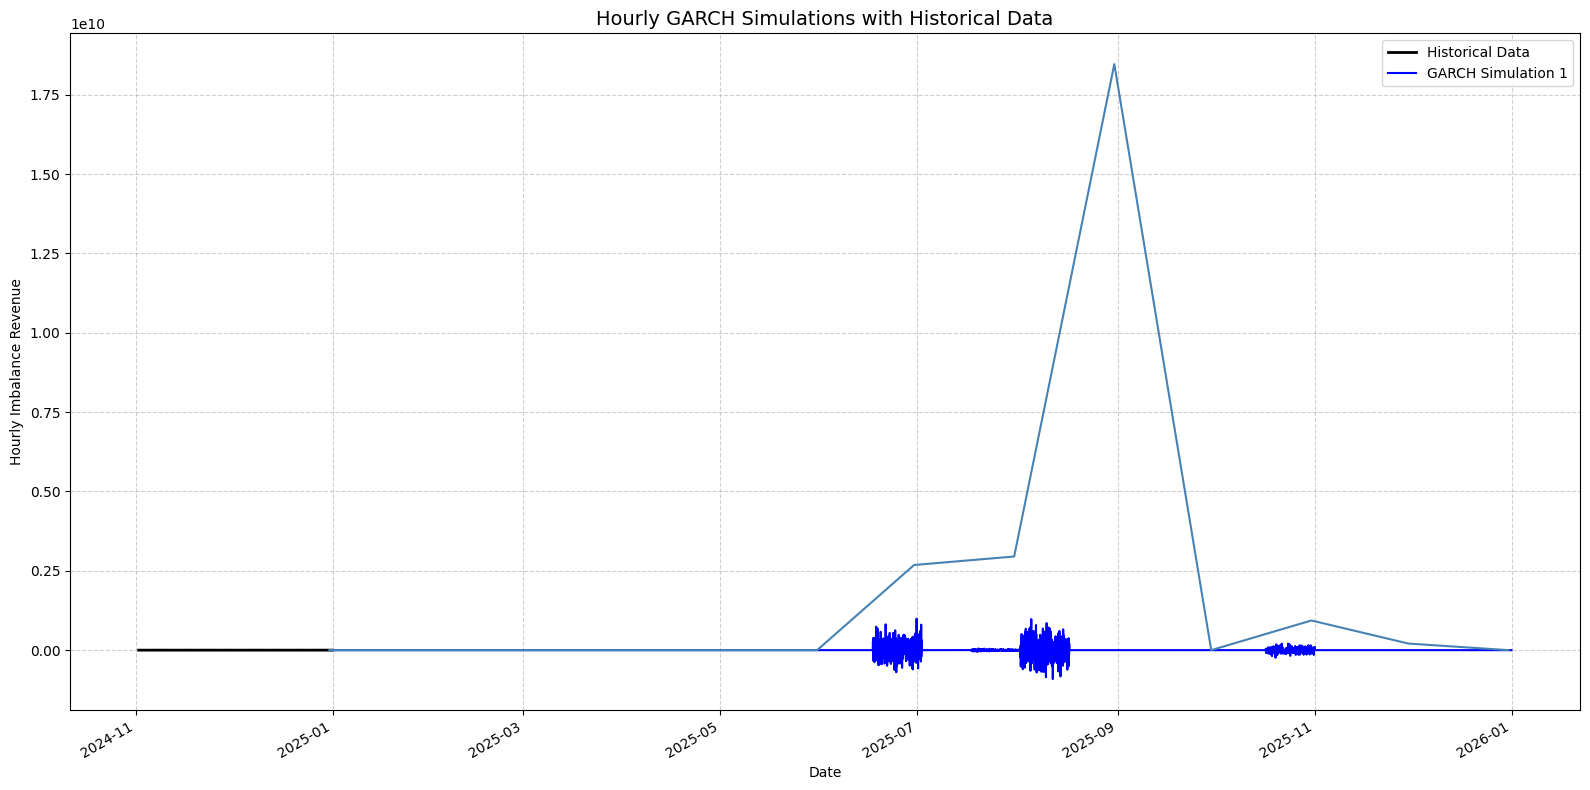

In [13]:
# Load and prepare data
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# Simulation settings
num_simulations = 1
forecast_days = 365
np.random.seed(14)

# Fit a GARCH(1,1) model for each hour
garch_models = {}
for hour in range(24):
    series = hourly_data[hourly_data["Hour"] == hour]["imbalance"]
    series = series - series.mean()
    model = arch_model(series, vol="Garch", p=1, q=1)
    fit_result = model.fit(disp="off")
    garch_models[hour] = {"model": model, "fit_result": fit_result}

# Simulate forecast_days of data per hour
simulations = {}
for i in range(num_simulations):
    sim_data = []
    for hour in range(24):
        sim = garch_models[hour]["model"].simulate(
            garch_models[hour]["fit_result"].params,
            nobs=forecast_days
)
        sim_data.append(sim['data'].values)

    sim_matrix = np.array(sim_data)
    sim_df = pd.DataFrame(sim_matrix, index=range(24), columns=[f"day_{d}" for d in range(forecast_days)])
    sim_df.index.name = "hour"
    simulations[f"simulation_{i}"] = sim_df

# Plotting
plt.figure(figsize=(16, 8))
# Plot last 2 months of historical data (48 days × 24 hours)
last_2months = hourly_data.iloc[-24*60:]
plt.plot(last_2months.index, last_2months["imbalance"], label="Historical Data", color="black", linewidth=2)

# Simulated future time range
start_date = hourly_data.index[-1] + pd.Timedelta(hours=1)
simulation_dates = pd.date_range(start=start_date, periods=24 * forecast_days, freq='h')

sim_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

# Plot each simulation
for i, (sim_key, sim_df) in enumerate(simulations.items()):
    flat_sim = sim_df.values.flatten()
    sim_series = pd.Series(flat_sim, index=simulation_dates)
    plt.plot(sim_series.index, sim_series, label=f"GARCH Simulation {i+1}", color=sim_colors[i % len(sim_colors)], linewidth=1.5)

    # Monthly aggregation of the forecast
    monthly_forecast = sim_series.resample("M").sum()
    monthly_forecast.plot(kind="line", color="steelblue")

plt.title("Hourly GARCH Simulations with Historical Data", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Hourly Imbalance Revenue")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
